### Define Circuit

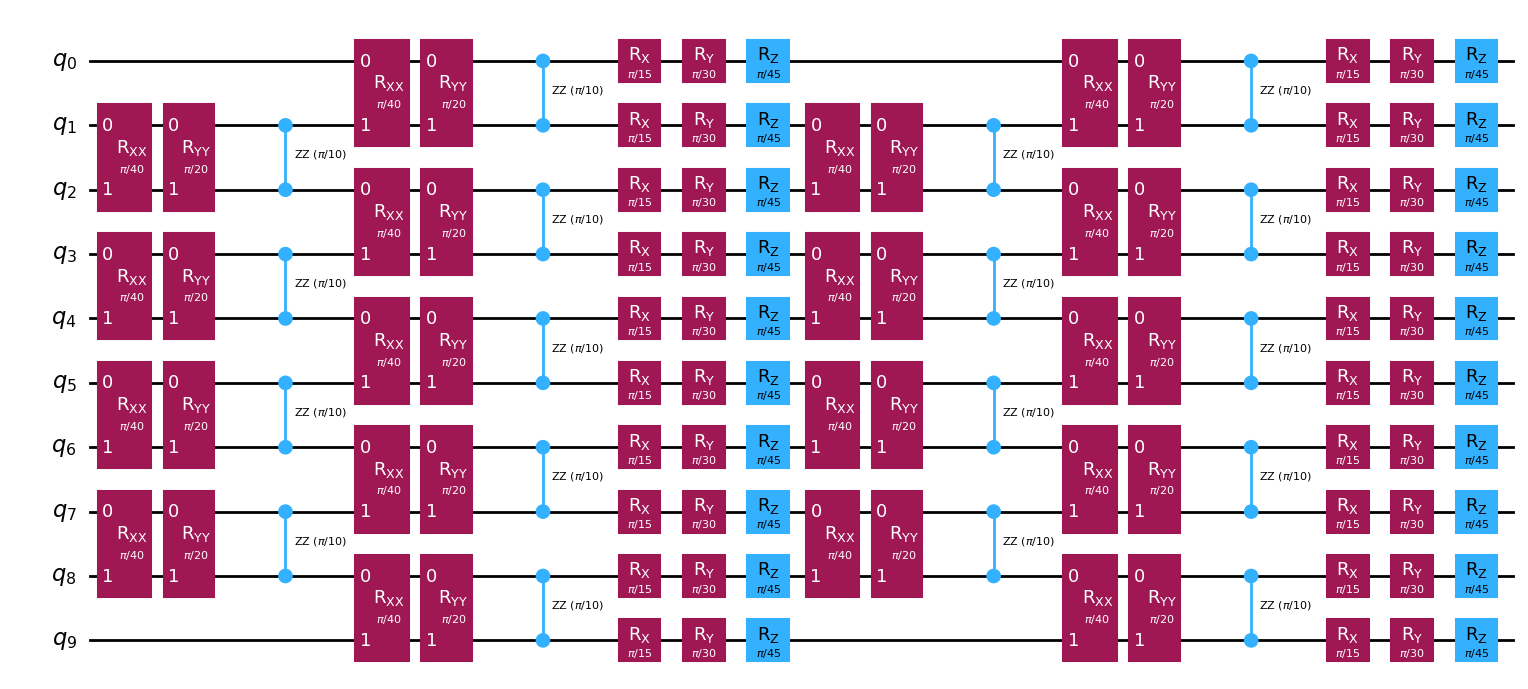

In [2]:
import numpy as np
from qiskit import QuantumCircuit
from qiskit_aer import AerSimulator
from qiskit.transpiler import CouplingMap
from qiskit.synthesis import LieTrotter
from qiskit.transpiler import generate_preset_pass_manager
from qiskit_ibm_runtime import QiskitRuntimeService, EstimatorV2, Batch
from qiskit_ibm_runtime.fake_provider import FakeMelbourneV2, FakeKolkataV2
from qiskit.primitives import StatevectorEstimator
from qiskit.quantum_info import SparsePauliOp
from qiskit_addon_utils.problem_generators import (
    generate_time_evolution_circuit,
    generate_xyz_hamiltonian,
)
from qiskit_addon_utils.slicing import slice_by_gate_types, slice_by_depth
from qiskit_addon_obp.utils.simplify import OperatorBudget
from qiskit_addon_obp.utils.truncating import setup_budget
from qiskit_addon_obp import backpropagate
from qiskit_addon_utils.slicing import combine_slices


coupling_map = CouplingMap.from_heavy_hex(3, bidirectional=False)

# Choose a 10-qubit linear chain on this coupling map
reduced_coupling_map = coupling_map.reduce(
    [0, 13, 1, 14, 10, 16, 5, 12, 8, 18]
)

# Get a qubit operator describing the Heisenberg XYZ model
hamiltonian = generate_xyz_hamiltonian(
    reduced_coupling_map,
    coupling_constants=(np.pi / 8, np.pi / 4, np.pi / 2),
    ext_magnetic_field=(np.pi / 3, np.pi / 6, np.pi / 9),
)

# we evolve for some time
circuit = generate_time_evolution_circuit(
    hamiltonian, synthesis=LieTrotter(reps=2), time=0.2
)

circuit.draw("mpl")

### Define Observable

In [3]:
# Specify a single-qubit observable
n=circuit.num_qubits
observable_terms = [
            "I"*(i-1) + "Z" + "I"*(n - i)
            for i in range(1, n+1)
        ]
observable = SparsePauliOp(observable_terms, coeffs=[1/(n)] * (n))
print(observable)

SparsePauliOp(['ZIIIIIIIII', 'IZIIIIIIII', 'IIZIIIIIII', 'IIIZIIIIII', 'IIIIZIIIII', 'IIIIIZIIII', 'IIIIIIZIII', 'IIIIIIIZII', 'IIIIIIIIZI', 'IIIIIIIIIZ'],
              coeffs=[0.1+0.j, 0.1+0.j, 0.1+0.j, 0.1+0.j, 0.1+0.j, 0.1+0.j, 0.1+0.j, 0.1+0.j,
 0.1+0.j, 0.1+0.j])


### Define Backend

In [4]:
service=QiskitRuntimeService(channel="ibm_cloud",token="n2Om3bZ5WlEvUWi6-Sudcxj5T_-vy3Ynj8-RrHnNU2Ca")
backend = service.least_busy(operational=True, simulator=False)
backend
#backend=FakeKolkataV2()

account.resolve_crn:WARNING:2025-06-12 10:01:17,344: Multiple CRN values found for service name None: ['crn:v1:bluemix:public:quantum-computing:eu-de:a/6c63dae5281147f1a0449b36e0aaba3a:a1eac29a-e646-40b9-b0ce-8eb6ce6e020a::', 'crn:v1:bluemix:public:quantum-computing:eu-de:a/6c63dae5281147f1a0449b36e0aaba3a:14fecd7a-ce9d-4be1-a40e-02c3a5dd25cf::', 'crn:v1:bluemix:public:quantum-computing:eu-de:a/6c63dae5281147f1a0449b36e0aaba3a:57328bd5-d7b9-4228-8b61-d93627893a9b::', 'crn:v1:bluemix:public:quantum-computing:eu-de:a/6c63dae5281147f1a0449b36e0aaba3a:410f0be9-c050-4c90-8b9b-822790d68495::', 'crn:v1:bluemix:public:quantum-computing:us-east:a/6c63dae5281147f1a0449b36e0aaba3a:dbe5b217-5192-407c-9420-7cd07af41e3e::', 'crn:v1:bluemix:public:quantum-computing:us-east:a/6c63dae5281147f1a0449b36e0aaba3a:068b8d3f-2983-4154-822a-f19a296847ec::', 'crn:v1:bluemix:public:quantum-computing:us-east:a/6c63dae5281147f1a0449b36e0aaba3a:20efd56a-3db0-4aa6-9c69-2686147fcb87::', 'crn:v1:bluemix:public:quantum

<IBMBackend('ibm_strasbourg')>

In [5]:
truncation_error_budget_list =[] # The list of errors to be used 
max_error_per_slice_list = np.linspace(0.0001,0.04,20)
for error in max_error_per_slice_list:
    trunc_budget = setup_budget(max_error_per_slice=error)
    truncation_error_budget_list.append(trunc_budget)
print(truncation_error_budget_list)

[TruncationErrorBudget(per_slice_budget=[np.float64(0.0001)], max_error_total=inf, p_norm=1, tol=1e-08), TruncationErrorBudget(per_slice_budget=[np.float64(0.0021999999999999997)], max_error_total=inf, p_norm=1, tol=1e-08), TruncationErrorBudget(per_slice_budget=[np.float64(0.0043)], max_error_total=inf, p_norm=1, tol=1e-08), TruncationErrorBudget(per_slice_budget=[np.float64(0.0064)], max_error_total=inf, p_norm=1, tol=1e-08), TruncationErrorBudget(per_slice_budget=[np.float64(0.008499999999999999)], max_error_total=inf, p_norm=1, tol=1e-08), TruncationErrorBudget(per_slice_budget=[np.float64(0.010599999999999998)], max_error_total=inf, p_norm=1, tol=1e-08), TruncationErrorBudget(per_slice_budget=[np.float64(0.0127)], max_error_total=inf, p_norm=1, tol=1e-08), TruncationErrorBudget(per_slice_budget=[np.float64(0.014799999999999999)], max_error_total=inf, p_norm=1, tol=1e-08), TruncationErrorBudget(per_slice_budget=[np.float64(0.0169)], max_error_total=inf, p_norm=1, tol=1e-08), Trunca

In [6]:
truncation_error_budget_list[:13]

[TruncationErrorBudget(per_slice_budget=[np.float64(0.0001)], max_error_total=inf, p_norm=1, tol=1e-08),
 TruncationErrorBudget(per_slice_budget=[np.float64(0.0021999999999999997)], max_error_total=inf, p_norm=1, tol=1e-08),
 TruncationErrorBudget(per_slice_budget=[np.float64(0.0043)], max_error_total=inf, p_norm=1, tol=1e-08),
 TruncationErrorBudget(per_slice_budget=[np.float64(0.0064)], max_error_total=inf, p_norm=1, tol=1e-08),
 TruncationErrorBudget(per_slice_budget=[np.float64(0.008499999999999999)], max_error_total=inf, p_norm=1, tol=1e-08),
 TruncationErrorBudget(per_slice_budget=[np.float64(0.010599999999999998)], max_error_total=inf, p_norm=1, tol=1e-08),
 TruncationErrorBudget(per_slice_budget=[np.float64(0.0127)], max_error_total=inf, p_norm=1, tol=1e-08),
 TruncationErrorBudget(per_slice_budget=[np.float64(0.014799999999999999)], max_error_total=inf, p_norm=1, tol=1e-08),
 TruncationErrorBudget(per_slice_budget=[np.float64(0.0169)], max_error_total=inf, p_norm=1, tol=1e-08)

In [7]:
pm = generate_preset_pass_manager(basis_gates=backend.configuration().basis_gates, optimization_level=3, seed_transpiler=1)

### Synthesize circ0, the original experiment (Synthesized circuit with no OBP)

In [8]:
circ0 = pm.run(circuit)
print(" The depth of the circuit with no OBP is : ",circ0.depth() )

 The depth of the circuit with no OBP is :  55


In [9]:
# Define an operator budget
op_budget = OperatorBudget(max_qwc_groups=8)

# Slice the isa_circuit by depth
synthesized_slices = slice_by_depth(circ0, max_slice_depth=1)
print(f"Slice_by_depth separated the circuit into {len(synthesized_slices)} slices.")

Slice_by_depth separated the circuit into 55 slices.


### Define circ1, the backpropagated circuit with no truncation

In [10]:
# Backpropagate without the truncation error budget
backpropagated_observable, remaining_slices, metadata = backpropagate(
    observable,
    synthesized_slices,
    operator_budget=op_budget,
)
# Recombine the slices remaining after backpropagation
circ1 = combine_slices(remaining_slices, include_barriers=False)

print(f"Depth of the backpropagated circuit with no truncation is: ", circ1.depth())

Depth of the backpropagated circuit with no truncation is:  37


In [9]:
#backpropagated_observable.group_commuting()

### Define circ2 to circ20

In [11]:
truncated_circs = []
truncated_observables=[]
# Backpropagate *with* the truncation error budget
for err in truncation_error_budget_list[:13]:
    backpropagated_observable_trunc, remaining_slices_trunc, metadata_trunc = backpropagate(
            observable,
            synthesized_slices,
            operator_budget=op_budget,
            truncation_error_budget=err,
        )

# Recombine the slices remaining after backpropagation
    bp_circuit_trunc = combine_slices(
        remaining_slices_trunc, include_barriers=False
    )
    if bp_circuit_trunc != None:
        truncated_circs.append(bp_circuit_trunc)
    else:
        bp_circuit_trunc =QuantumCircuit(circuit.num_qubits)
        truncated_circs.append(bp_circuit_trunc)
    truncated_observables.append(backpropagated_observable_trunc) # truncated observables appended
print(truncated_circs)
    #bp_circuit_trunc.draw("mpl")
#print(truncated_observables)




for truncated_circ in truncated_circs:
    if truncated_circ != None:
        print(f"Depth of the truncated backpropagated circuit is: ", truncated_circ.depth())
    else:
        print(f"Depth of the truncated backpropagated circuit is: ", 0)



[<qiskit.circuit.quantumcircuit.QuantumCircuit object at 0x12a634260>, <qiskit.circuit.quantumcircuit.QuantumCircuit object at 0x12b8129c0>, <qiskit.circuit.quantumcircuit.QuantumCircuit object at 0x12bd3fb60>, <qiskit.circuit.quantumcircuit.QuantumCircuit object at 0x12bd2ff20>, <qiskit.circuit.quantumcircuit.QuantumCircuit object at 0x12bd4f9b0>, <qiskit.circuit.quantumcircuit.QuantumCircuit object at 0x12bd14c80>, <qiskit.circuit.quantumcircuit.QuantumCircuit object at 0x12a6e9bb0>, <qiskit.circuit.quantumcircuit.QuantumCircuit object at 0x12bd10800>, <qiskit.circuit.quantumcircuit.QuantumCircuit object at 0x12bd2ddf0>, <qiskit.circuit.quantumcircuit.QuantumCircuit object at 0x12bd5a780>, <qiskit.circuit.quantumcircuit.QuantumCircuit object at 0x12bd3f350>, <qiskit.circuit.quantumcircuit.QuantumCircuit object at 0x12bd6f1d0>, <qiskit.circuit.quantumcircuit.QuantumCircuit object at 0x12bd10bc0>]
Depth of the truncated backpropagated circuit is:  37
Depth of the truncated backpropagat

In [12]:
truncated_circs_isa=[]
observable_truncated_circs_isa =[]
truncated_circuit_depths = []
pass_manager =generate_preset_pass_manager(optimization_level=3, backend=backend, seed_transpiler=1)

circ0_isa =pass_manager.run(circ0)
observable_isa_circ0 = observable.apply_layout(circ0_isa.layout)
truncated_circuit_depths.append(circ0_isa.depth())
circ1_isa =pass_manager.run(circ1)
observable_isa_circ1 = backpropagated_observable.apply_layout(circ1_isa.layout)
truncated_circuit_depths.append(circ1_isa.depth())
for ckt,trunc_obs in zip(truncated_circs,truncated_observables):
        truncated_circ_isa = pass_manager.run(ckt)
        observable_isa_trunc_circ = trunc_obs.apply_layout(truncated_circ_isa.layout)
        truncated_circs_isa.append(truncated_circ_isa)
        observable_truncated_circs_isa.append(observable_isa_trunc_circ)

for truncated_ckt in truncated_circs_isa:
    if truncated_ckt != None:
        depth = truncated_ckt.depth()
        truncated_circuit_depths.append(depth)
    else:
        truncated_circuit_depths.append(0)

print(truncated_circuit_depths)



[56, 38, 38, 32, 32, 32, 32, 32, 32, 32, 32, 19, 19, 7, 0]


In [14]:
estimator_ideal = EstimatorV2(mode=AerSimulator())
result_ideal =(
    estimator_ideal.run([(circ0_isa, observable_isa_circ0)]).result()[0].data.evs.item()
)
print("The ideal expectation value is : ", result_ideal)

The ideal expectation value is :  0.8841308593750001


In [15]:
job =[]
with Batch(backend=backend) as batch:
    estimator=EstimatorV2(mode=batch)
    pub0 = (circ0_isa,observable_isa_circ0)
    job0=estimator.run([pub0,pub0,pub0,pub0,pub0])
    job.append(job0)

    pub1 = (circ1_isa,observable_isa_circ1)
    job1=estimator.run([pub1,pub1,pub1,pub1,pub1])
    job.append(job1)

    for circ_err,obs_err in zip(truncated_circs_isa, observable_truncated_circs_isa):
        puberr= (circ_err,obs_err)
        job_err = estimator.run([puberr,puberr,puberr,puberr,puberr])
        job.append(job_err)


In [17]:
batch_id = batch.session_id
print(batch_id)

79a11041-b722-436d-8994-87f0f2e4f8da


In [18]:
batch.status()

'Closed'

In [19]:
job[0].result()[0].data.evs.item()

0.8190748191429535

In [20]:
exp_vals = []
for j in job:
    exp_vals.append((j.result()[0].data.evs.item(),
                      j.result()[1].data.evs.item(),
                      j.result()[2].data.evs.item(),
                      j.result()[3].data.evs.item(),
                      j.result()[4].data.evs.item()))
print(exp_vals)

[(0.8190748191429535, 0.8242702638016133, 0.8229520007632403, 0.8224389908266351, 0.8203366277876531), (0.8319391415330963, 0.8283938558150145, 0.8146495875956896, 0.8221626140669194, 0.8383253170431888), (0.8275102009696527, 0.8151457992642857, 0.8076804140143594, 0.8080064845502682, 0.8183440081668835), (0.8497997835477024, 0.8581340973860317, 0.8460591110614759, 0.8461666740269265, 0.8540424757912671), (0.847118125675971, 0.8468302203458595, 0.8517696346078973, 0.8491722837997326, 0.8511971013155899), (0.8517927409656154, 0.8412628909875712, 0.8463103698965122, 0.8426027241988837, 0.849135748054848), (0.8240950578418537, 0.8243234796269355, 0.8246307479870303, 0.8305706946439461, 0.8304831023291475), (0.788345313720635, 0.7890122610428116, 0.7845296627171742, 0.8269108584476401, 0.8300014547351592), (0.821749150498037, 0.8181933966583186, 0.8207603046638068, 0.8199534687211423, 0.8161610101040047), (0.8129938618328842, 0.8158131324221796, 0.8136950262440337, 0.813912632910815, 0.821

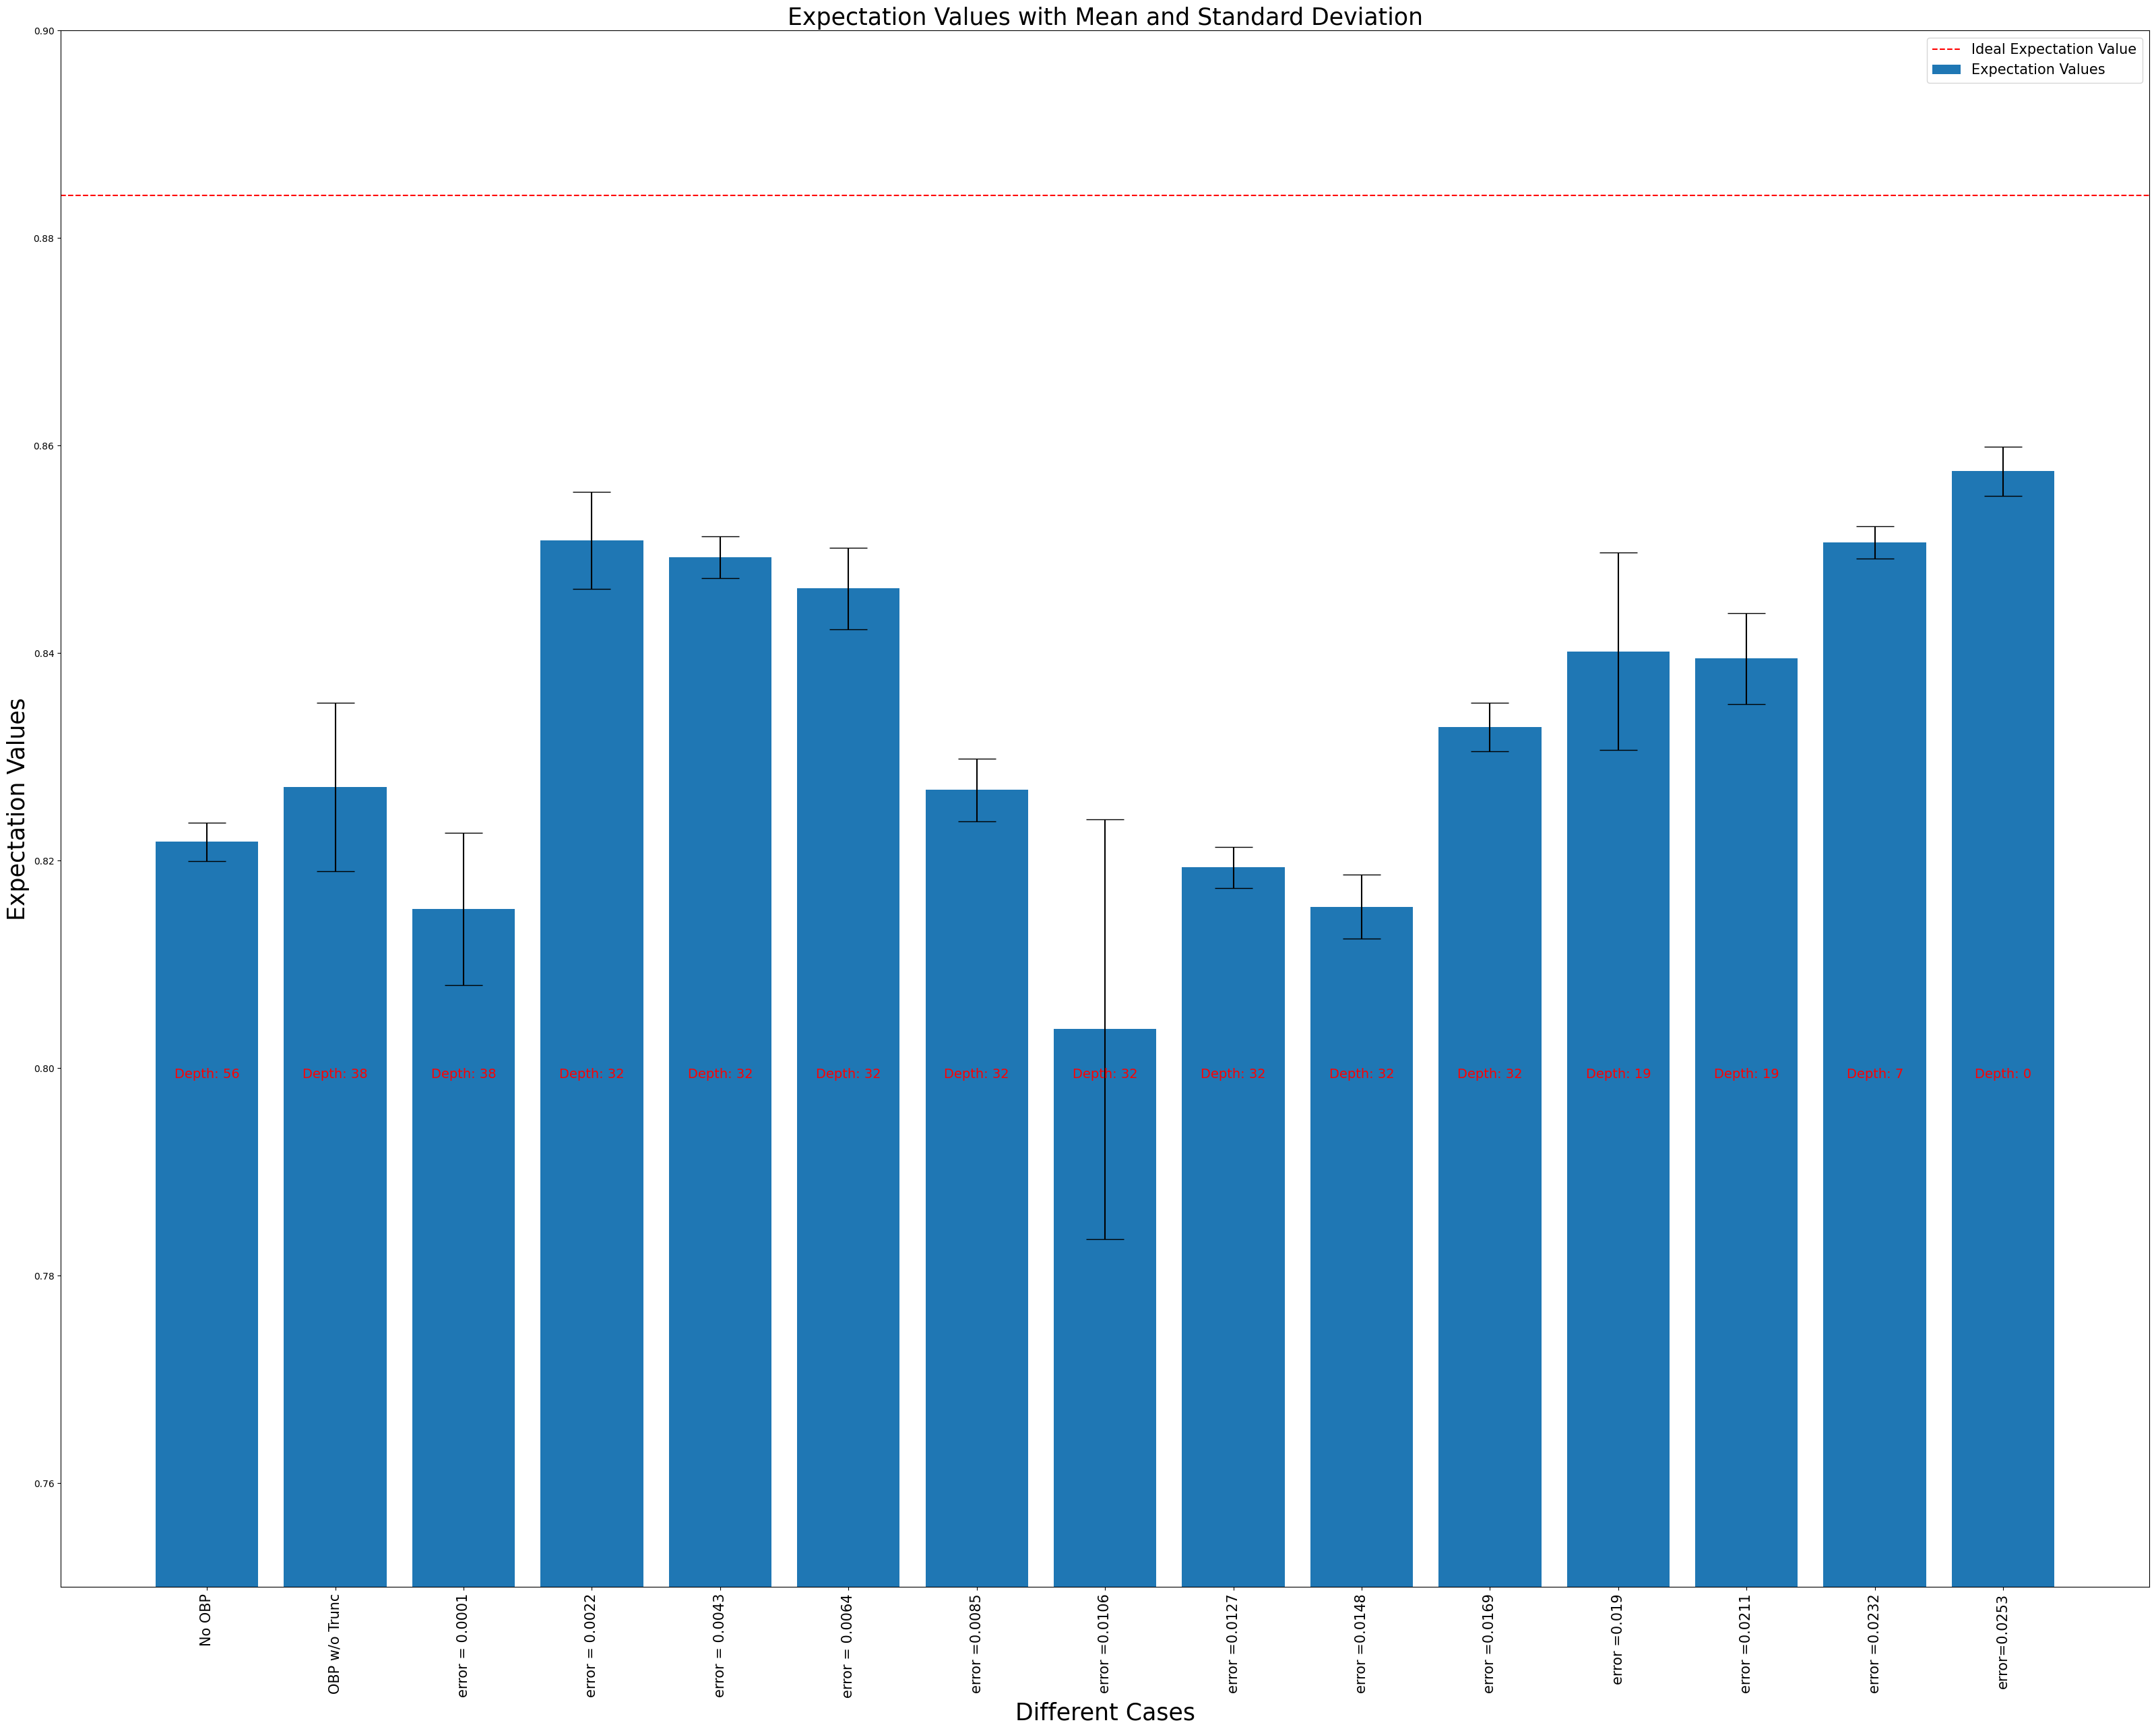

In [29]:
import matplotlib.pyplot as plt
import numpy as np

means = [np.mean(t) for t in exp_vals]
std_devs = [np.std(t) for t in exp_vals]
#print(means)

bar_lengths = means
error_bars = std_devs

#x_pos = np.arange(1, 23)
fig, ax = plt.subplots(figsize=(40,30))
labels=['No OBP', 'OBP w/o Trunc', 'error = 0.0001', 'error = 0.0022','error = 0.0043', 'error = 0.0064', 'error =0.0085', 'error =0.0106','error =0.0127','error =0.0148','error =0.0169','error =0.019','error =0.0211','error =0.0232', 'error=0.0253']
ax.set_xticks(range(len(labels)))
ax.set_xticklabels(labels, rotation=90, fontsize=15)

x_pos = range(len(labels))  # same length as your data
ax.bar(x_pos, bar_lengths, yerr=error_bars, capsize=20, label='Expectation Values')

for i, depth in enumerate(truncated_circuit_depths):
    ax.text(x_pos[i], 0.8, f'Depth: {int(depth)}', ha='center', va='top', fontsize=14, color='red')
ax.set_xlabel("Different Cases", fontsize=25)
ax.set_ylabel("Expectation Values", fontsize=25)
ax.set_title("Expectation Values with Mean and Standard Deviation", fontsize=25)
# Adjust plot limits to avoid cutting off text
ax.set_ylim([0.75, 0.9])
plt.axhline(y=result_ideal, color='r', linestyle='--', label='Ideal Expectation Value')
plt.legend(fontsize=15)
plt.show()
